In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random
import time
import struct
from array import array

In [ ]:
train_data_name= '/content/drive/MyDrive/MNIST/train-images-idx3-ubyte'
train_labels_name= '/content/drive/MyDrive/MNIST/train-labels-idx1-ubyte'
test_data_name= '/content/drive/MyDrive/MNIST/t10k-images-idx3-ubyte'
test_labels_name = '/content/drive/MyDrive/MNIST/t10k-labels-idx1-ubyte'

In [ ]:
class MnistDataloader(object):
    def __init__(self, training_data_file,training_labels_file, test_data_file, test_labels_file):
        self.training_data_file = training_data_file
        self.training_labels_file = training_labels_file
        self.test_data_file = test_data_file
        self.test_labels_file = test_labels_file
    
    def read_images_labels(self, features_file, target_file):        
        labels = []
        with open(target_file, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Mismatch! Expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(features_file, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Mismatch! Expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            #print('image size: ', img.shape)
            images[i][:] = img            
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_data_file, self.training_labels_file)
        x_test, y_test = self.read_images_labels(self.test_data_file, self.test_labels_file)
        return (x_train, y_train),(x_test, y_test) 

In [ ]:
mnist_dataloader = MnistDataloader(train_data_name, train_labels_name, test_data_name, test_labels_name)
(train_X, train_labels), (test_X, test_labels) = mnist_dataloader.load_data()

(train_X, train_labels), (test_X, test_labels) = mnist_dataloader.load_data()

train_X= np.array(train_X, dtype="int")
train_labels= np.array(train_labels, dtype="int").reshape(-1, 1)
test_X= np.array(test_X,dtype="int")
test_labels= np.array(test_labels, dtype="int").reshape(-1, 1)

#shape of dataset
print('X_train: ' + str(train_X.shape))
print('Y_train: ' + str(train_labels.shape))
print('X_test:  '  + str(test_X.shape))
print('Y_test:  '  + str(test_labels.shape))

X_train: (60000, 28, 28)
Y_train: (60000, 1)
X_test:  (10000, 28, 28)
Y_test:  (10000, 1)


In [ ]:
train_X= train_X.reshape(train_X.shape[0], 784)
test_X= test_X.reshape(test_X.shape[0], 784)

# Binaru classify Label 
train_labels[train_labels<5] = 0
train_labels[train_labels>4] = 1
test_labels[test_labels<5] = 0
test_labels[test_labels>4] = 1


In [ ]:
# Train set normalization
train_X= train_X.astype('float64')
test_X= test_X.astype('float64')

train_X -= np.mean(train_X, axis=1).reshape(60000,1)
test_X -= np.mean(test_X, axis=1).reshape(10000,1)
train_X /= np.std(train_X, axis=1).reshape(60000,1)
test_X /= np.std(test_X, axis=1).reshape(10000,1)

In [ ]:
# Add bias

train_X= np.append(train_X, np.ones([train_X.shape[0], 1], dtype = float), axis=1 ) 
test_X= np.append(test_X, np.ones([test_X.shape[0], 1], dtype = float), axis=1 ) 

In [ ]:
#create validation set
val_X= train_X[-10000:]
val_Y= train_labels[-10000:]
train_X= train_X[:50000]
train_labels= train_labels[:50000]


In [ ]:
#shuffle training data
np.random.seed(9)
shuff_index= np.random.permutation(train_X.shape[0], )

train_X = train_X[shuff_index]
train_labels= train_labels[shuff_index]

In [ ]:
# Linear Classifier
eta= [0.0001, 0.00001, 0.0003, 0.00003, 0.00002]
batchsize= 10
val_acc_list= [] 
train_acc_list=[]
train_loss=[]
V_list= []
for lr in eta:
    V= np.random.randn(train_X.shape[1] , 1) * np.sqrt(2/1)
    for i in range(10):
        for j in range(0,50000,batchsize):
            #if j%2000 == 0:
            #    print(j)
            mini_X= train_X[j: j+batchsize]
            mini_Y= train_labels[j:j+batchsize].reshape(-1, 1)
            #print(V.shape, mini_X.shape)
            predict = np.dot(mini_X, V)
            predict_loss = mini_Y - predict
            #print('predict_loss shape: ', predict_loss.shape, mini_Y.shape, predict.shape)
            delta_V = -np.dot(mini_X.T, predict_loss)
            #print('delta_Vshape: ', delta_V.shape, V.shape)
            V -= lr*delta_V
    V_list.append(V)
    predict = np.dot(val_X, V)
    predict[predict<0.5] = 0
    predict[predict>=0.5] = 1
    accuracy = np.sum(predict == val_Y.reshape(-1,1))/val_Y.shape[0]
    print("Linear classifier Base validation accuracy with lr {0}:  {1}%".format(lr, 100*accuracy))

Linear classifier Base validation accuracy with lr 0.0001:  61.839999999999996%
Linear classifier Base validation accuracy with lr 1e-05:  53.14%
Linear classifier Base validation accuracy with lr 0.0003:  79.22%
Linear classifier Base validation accuracy with lr 3e-05:  55.55%
Linear classifier Base validation accuracy with lr 2e-05:  53.580000000000005%


#### Learning rate 0.0003 gives higher accuracy. We will test the accuracy of test set now.

In [ ]:
predict = np.dot(test_X, V_list[2])
predict[predict<0.5] = 0
predict[predict>=0.5] = 1
accuracy = np.sum(predict == test_labels.reshape(-1,1))/test_labels.shape[0]
print("Linear classifier Test accuracy with lr {0}:  {1}%".format(0.0003, 100*accuracy))

Linear classifier Test accuracy with lr 0.0003:  80.33%


In [ ]:
def sigmoid_activation(X, deriv= False):
    output = 1 / (1 + np.exp(-X))

    if deriv == True:
        sigmoid_prime= np.multiply(X, (1 - X))
        return sigmoid_prime
    return output


def reLU_activation(X, deriv= False):
    output = np.maximum(0.0, X)

    if deriv == True:
        relu_prime= (X > 0)+0
        return relu_prime
    return output
    

In [ ]:
def feed_forward_network(X_mini, W, V, baseline= False, loss= 'quad'):
    Wx= np.dot(W.T, X_mini)
    relu_WX= reLU_activation(Wx)
    output= np.dot(V.T, relu_WX)

    if loss== 'logistic':
        output= sigmoid_activation(output)

    if baseline == True: 
        y= np.dot(W.T, X)

    return relu_WX, Wx, output


def backpropagation_cal(Wx, mini_X, true_Y,relu_WX, output):

    error_wrt_output = -(true_Y - output) #/ mini_Y.shape
    delta_output= np.dot(relu_WX, error_wrt_output.T)

    hidden_layer_deriv= reLU_activation(Wx, True)
    delta_layer1= np.dot( mini_X, ( hidden_layer_deriv * np.dot( V, error_wrt_output)).T ) 


    return delta_layer1, delta_output


In [ ]:
def cal_accuracy_and_loss(X, Y, W, V, batchsize, loss= 'quad'):
    z_1= np.dot(W.T, X)
    a_1= reLU_activation(z_1)
    predict= np.dot(V.T, a_1)

    if loss== 'logistic':
        predict= sigmoid_activation(predict)
    
    predict= (predict > 0.5)+0
    Y= Y.reshape(1, -1)
    acc= np.round( ((np.sum(predict == Y)/ Y.shape[1]) *100), 3)
    return acc

In [ ]:
batchsize= 10
eta= [0.00003, 0.00007, 0.0007] 
inputlayer_neurons= 785
output_neurons= 1
hiddenlayer_neurons= [5, 40, 200]
val_accuracy= []
train_accuracy_list= []

<Figure size 432x288 with 0 Axes>

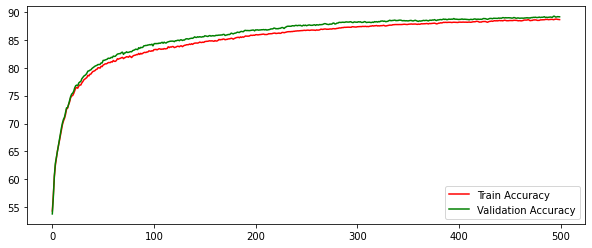

Training accuracy= 88.638% and Validation accuracy = 89.14%
Final test accuracy with 5 neurons is : 89.43% 


<Figure size 432x288 with 0 Axes>

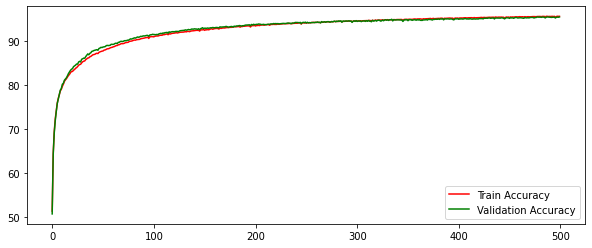

Training accuracy= 95.68% and Validation accuracy = 95.53%
Final test accuracy with 40 neurons is : 95.06% 


<Figure size 432x288 with 0 Axes>

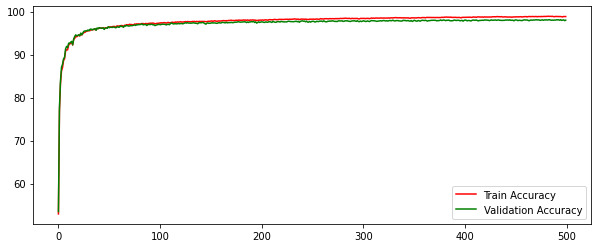

Training accuracy= 98.828% and Validation accuracy = 97.99%
Final test accuracy with 200 neurons is : 97.93% 


In [ ]:
# Quadratic Loss Neural Network
V_list=[]
W_list=[]
for ind,k in enumerate(hiddenlayer_neurons):
    W= np.random.randn(inputlayer_neurons, k) * np.sqrt(1/(inputlayer_neurons+k))
    V= np.random.randn(k , output_neurons) * np.sqrt(1/(k+output_neurons))
    c=0
    lr= eta[ind]
    val_accuracy.clear()
    train_accuracy_list.clear()
    for epoch in range(0,10):
        #print("Epoch : ", epoch)
        for i in range(0, 50000, batchsize):
            
            #if i%25000==0:
            #    print('Batch : ', i)
            mini_X= train_X[i: i+batchsize].T
            mini_Y= train_labels[i:i+batchsize].T
            
            #feed forward
            relu_WX, Wx, output= feed_forward_network(mini_X, W, V)
    
            #backpropagation:
            delta_layer1, delta_output = backpropagation_cal(Wx, mini_X, mini_Y,relu_WX, output)
            V= V - (lr *delta_output)
            W= W - (lr *delta_layer1)
    
    
            if c%100 ==0:
                accuracy= cal_accuracy_and_loss(val_X.T, val_Y, W, V, batchsize)
                val_accuracy.append(accuracy)
                train_accuracy= cal_accuracy_and_loss(train_X.T, train_labels, W, V, batchsize)
                train_accuracy_list.append(train_accuracy)
            c=c+1

    V_list.append(V)
    W_list.append(W)
    
    # Ploting Training and Validation accuracy
    plt.figure()
    fig, ax = plt.subplots(1, figsize=(10,4))
    ax.plot(train_accuracy_list,'r',label="Train Accuracy")
    ax.plot(val_accuracy, 'g',label="Validation Accuracy")
    ax.legend()
    plt.show()
    
    #Calculate test accuracy
    test_accuracy= cal_accuracy_and_loss(test_X.T, test_labels, W, V, batchsize)
    print('Training accuracy= {0}% and Validation accuracy = {1}%'.format(train_accuracy_list[-1], val_accuracy[-1]))
    print("Final test accuracy with {0} neurons is : {1}% ".format(k, test_accuracy))

<Figure size 432x288 with 0 Axes>

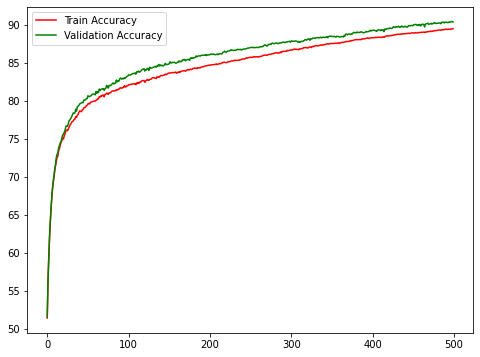

Training accuracy= 89.474% and Validation accuracy = 90.37%
Test accuracy with 5 neurons is : 90.26% 


<Figure size 432x288 with 0 Axes>

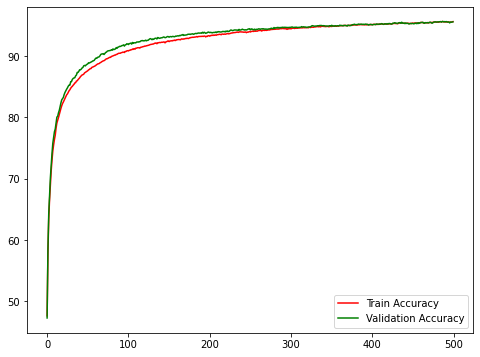

Training accuracy= 95.62% and Validation accuracy = 95.58%
Test accuracy with 40 neurons is : 95.0% 


<Figure size 432x288 with 0 Axes>

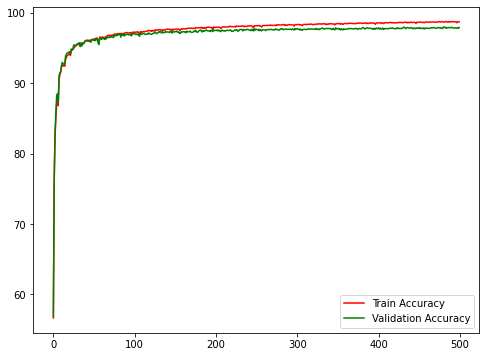

Training accuracy= 98.734% and Validation accuracy = 97.92%
Test accuracy with 200 neurons is : 97.77% 


In [ ]:
#Quadratic loss neural network
eta= [0.00003, 0.00007, 0.0007]

for ind,k in enumerate(hiddenlayer_neurons):
    W= np.random.randn(inputlayer_neurons, k) * np.sqrt(1/(inputlayer_neurons+k))
    V= np.random.randn(k , output_neurons) * np.sqrt(1/(output_neurons+k))
    c=0
    lr= eta[ind]
    val_accuracy.clear()
    train_accuracy_list.clear()
    for epoch in range(0,10):
        #print("Epoch : ", epoch)
        for i in range(0, 50000, batchsize):
            
            #if i%25000==0:
            #    print('Batch : ', i)
            mini_X= train_X[i: i+batchsize].T
            mini_Y= train_labels[i:i+batchsize].T
            
            #feed forward
            relu_WX, Wx, output= feed_forward_network(mini_X, W, V, 'logistic')
    
            #backpropagation:
            delta_layer1, delta_output = backpropagation_cal(Wx, mini_X, mini_Y,relu_WX, output)
            V= V - (lr *delta_output)
            W= W - (lr *delta_layer1)
    
    
            if c%100 ==0:
                accuracy= cal_accuracy_and_loss(val_X.T, val_Y, W, V, batchsize)
                val_accuracy.append(accuracy)
                train_accuracy= cal_accuracy_and_loss(train_X.T, train_labels, W, V, batchsize)
                train_accuracy_list.append(train_accuracy)
            c=c+1


    # Ploting Training and Test accuracy
    plt.figure()
    fig, ax = plt.subplots(1, figsize=(8,6))
    ax.plot(train_accuracy_list,'r',label="Train Accuracy")
    ax.plot(val_accuracy, 'g',label="Validation Accuracy")
    ax.legend()
    plt.show()
    

    #Calculate test accuracy
    test_accuracy= cal_accuracy_and_loss(test_X.T, test_labels, W, V, batchsize)
    print('Training accuracy= {0}% and Validation accuracy = {1}%'.format(train_accuracy_list[-1], val_accuracy[-1]))
    print("Test accuracy with {0} neurons is : {1}% ".format(k, test_accuracy))



### Role of number of Hidden units

For both models as number of hidden units increases, the  model learns better and gives higher accuracy. The reason for this is that if number of hidden units is low, then the model won't be able to represent/learn each class properly, with more hidden units the model is able to do so properly.


### Difference between Linear model and Neutral model

The linear classifier model gives around 80% accuracy while the Neural network gives around 97% accuracy. The neural network is able to perform far better that linera model as it is able to learn non-linear complexities in data. 

### Differences between logistic and quadratic loss

Neural network with logistic loss has slight better accuracy than quadratic loss for each case in change of neurons. In logistic loss we penalise the model with respect to all the classes, but in quadratic loss we penalise with respect to the actual class. So in case of logistic loss, it gets more penalty than quadratic loss.